In [2]:
# Importing packages

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Reading the training and test file
train = pd.read_csv("practice_problem\\data\\Train\\Train_SU63ISt.csv")
test = pd.read_csv("practice_problem\\data\\Test\\Test_0qrQsBZ.csv")

# Making a copy of training and test file
train_original = train.copy()
test_original = test.copy()

In [4]:
# Changing the datetime to datetime format
train['Datetime'] = pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M')
test['Datetime'] = pd.to_datetime(test.Datetime, format='%d-%m-%Y %H:%M')
train_original['Datetime'] = pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M')
test_original['Datetime'] = pd.to_datetime(test.Datetime, format='%d-%m-%Y %H:%M')

In [5]:
# Getting the year, Month, Day and Hour from Datetime
for df in (train, test, train_original, test_original):
    df['year'] = df.Datetime.dt.year
    df['month'] = df.Datetime.dt.month
    df['day'] = df.Datetime.dt.day
    df['hour'] = df.Datetime.dt.hour

In [6]:
# Getting the day of week
train['Day_of_week'] = train['Datetime'].dt.dayofweek
temp = train['Datetime']

In [7]:
# Adding new feature whether it's a weekend or not
def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0


temp2 = train['Datetime'].apply(applyer)
train['weekend'] = temp2
train = train.drop("ID", 1)

In [8]:
# ======================================================================
# Aggregating the hour data to daily data
# ======================================================================
# Train file
train.Timestamp = pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M')
train.index = train.Timestamp

# Converting to daily mean
train = train.resample('D').mean()

# Test file
test.Timestamp = pd.to_datetime(test.Datetime, format='%d-%m-%Y %H:%M') 
test.index = test.Timestamp 

# Converting to daily mean
test = test.resample('D').mean()

In [9]:
# Splitting to train and validation set
Train = train.ix['2012-08-25':'2014-06-24']
valid = train.ix['2014-06-25':'2014-09-25']

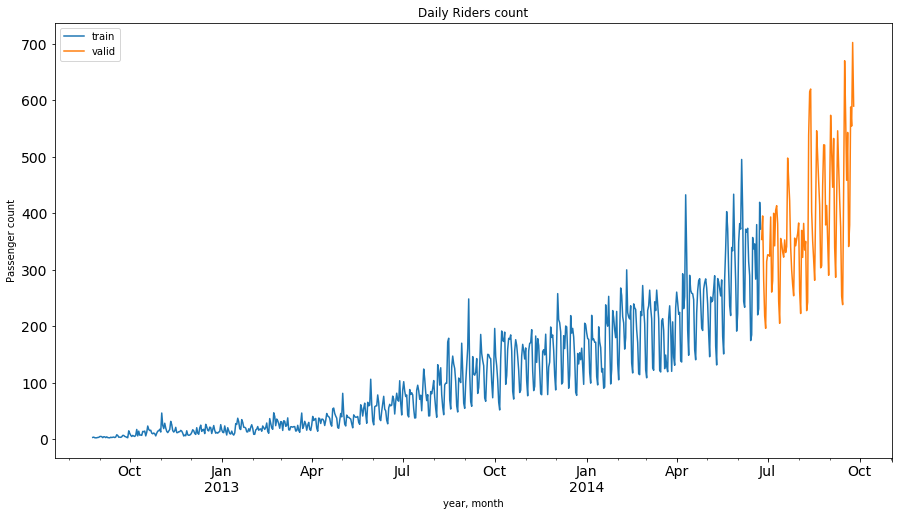

In [10]:
# Plot of Train and validation set
Train.Count.plot(figsize=(15, 8), title="Daily Riders count", fontsize=14, label='train')
valid.Count.plot(figsize=(15, 8), title="Daily Riders count", fontsize=14, label='valid')
plt.xlabel("year, month")
plt.ylabel("Passenger count")
plt.legend(loc='best')
plt.show()

In [11]:
# Time Series Decomposition - Original data
sm.tsa.seasonal_decompose(Train.Count).plot()
result = sm.tsa.stattools.adfuller(train.Count)
plt.show()

Dickey Fuller Test

In [12]:
# Testing stationarity
def test_stationary(timeseries):
    rolmean = timeseries.rolling(24).mean()
    rolstd = timeseries.rolling(24).std()
    
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label="Rolling mean")
    std = plt.plot(rolstd, color='black', label='Rolling std')
    plt.legend(loc='best')
    plt.show(block=False)
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

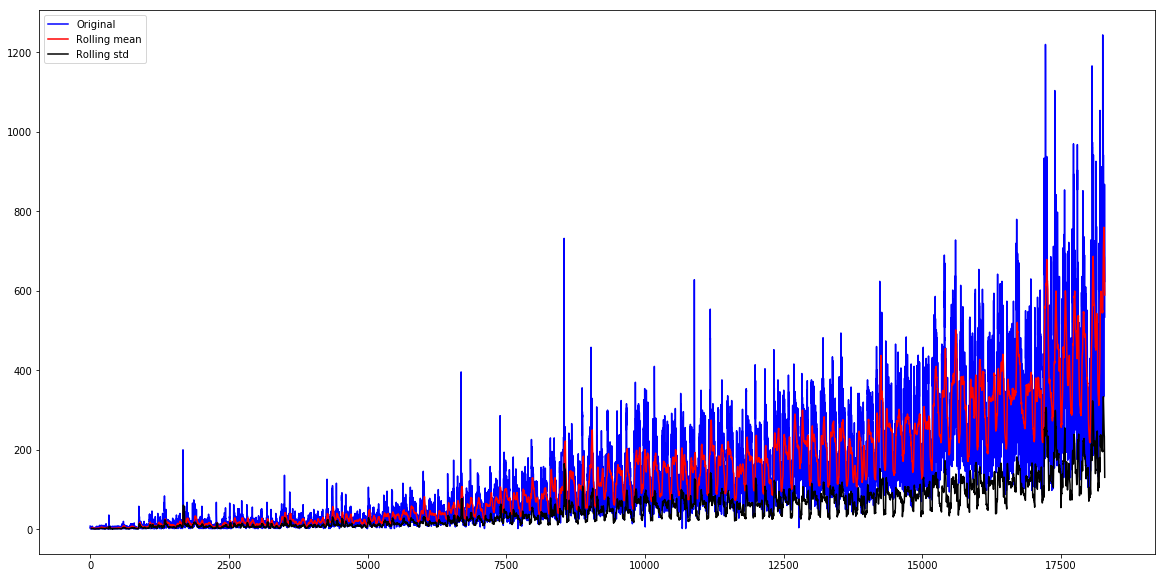

Results of Dickey-Fuller Test:


Test Statistic                    -4.456561
p-value                            0.000235
#Lags Used                        45.000000
Number of Observations Used    18242.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


In [13]:
test_stationary(train_original['Count'])

In [14]:
# Increasing trend - apply Log transformation which penalizes higher values more than smaller ones
Train_log = np.log(Train['Count'])
valid_log = np.log(valid['Count'])

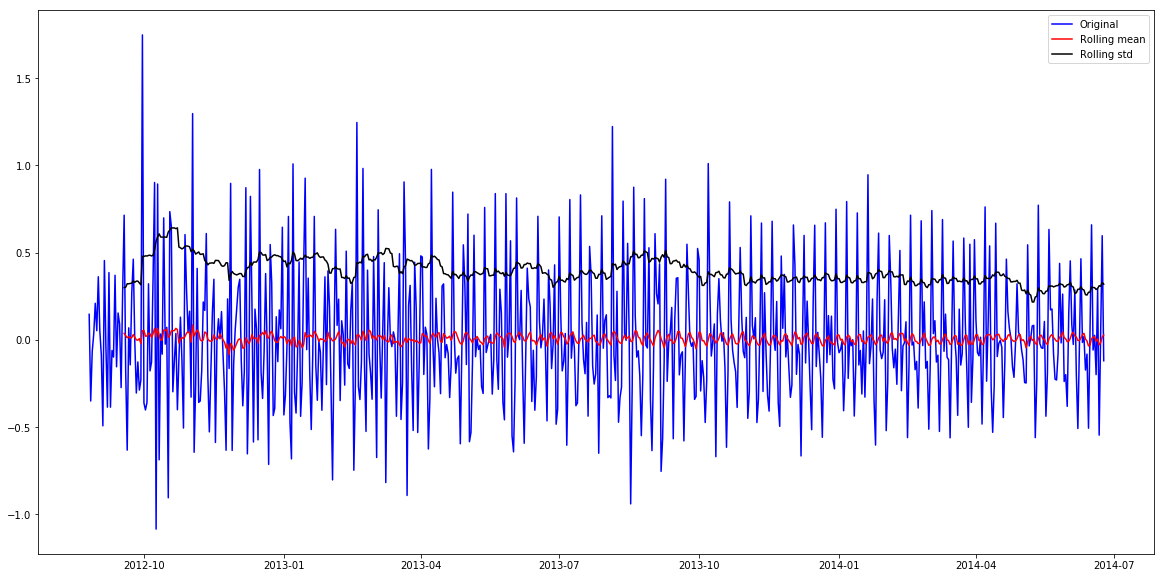

Results of Dickey-Fuller Test:
Test Statistic                -8.237568e+00
p-value                        5.834049e-13
#Lags Used                     1.900000e+01
Number of Observations Used    6.480000e+02
Critical Value (1%)           -3.440482e+00
Critical Value (5%)           -2.866011e+00
Critical Value (10%)          -2.569151e+00
dtype: float64


In [15]:
# Stabilising the mean of the time series and checking the stationarity
train_log_diff = Train_log - Train_log.shift(1)
test_stationary(train_log_diff.dropna())

In [16]:
# Seasonal decomposition of time series - log transform data
decomposition = seasonal_decompose(pd.DataFrame(Train_log).Count.values, freq=24)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(Train_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

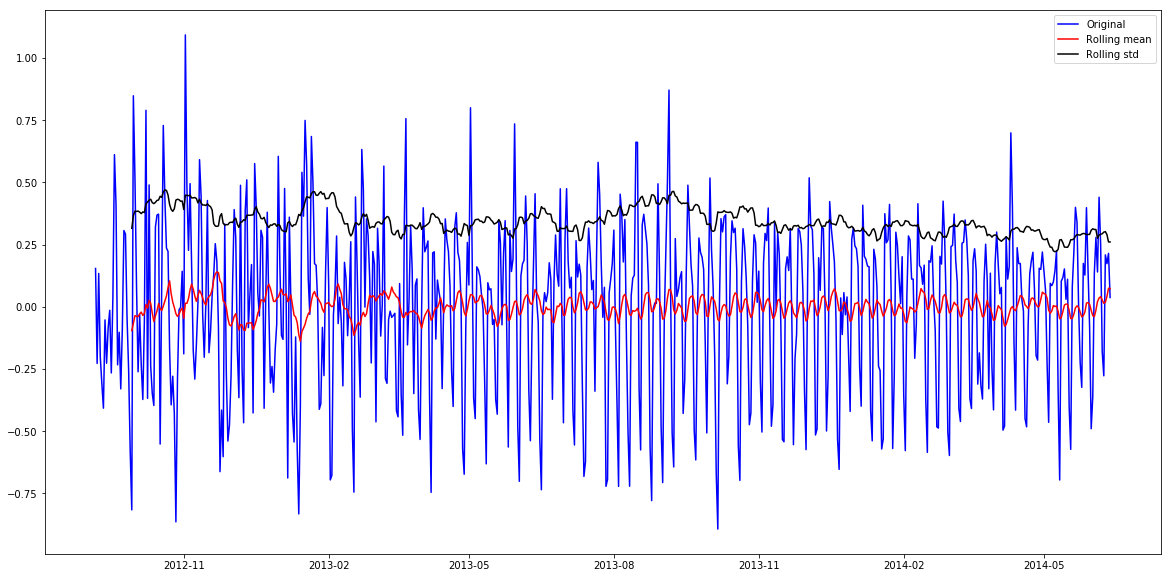

Results of Dickey-Fuller Test:
Test Statistic                -7.822096e+00
p-value                        6.628321e-12
#Lags Used                     2.000000e+01
Number of Observations Used    6.240000e+02
Critical Value (1%)           -3.440873e+00
Critical Value (5%)           -2.866183e+00
Critical Value (10%)          -2.569243e+00
dtype: float64


In [17]:
# Stationarity check - Residual
train_log_decompose = pd.DataFrame(residual)
train_log_decompose['date'] = Train_log.index
train_log_decompose.set_index('date', inplace=True)
train_log_decompose.dropna(inplace=True)
test_stationary(train_log_decompose[0])

ACF AND PACF

In [18]:
# ACF and PACF
lag_acf = acf(train_log_diff.dropna(), nlags=25)
lag_pacf = pacf(train_log_diff.dropna(), nlags=25, method='ols')

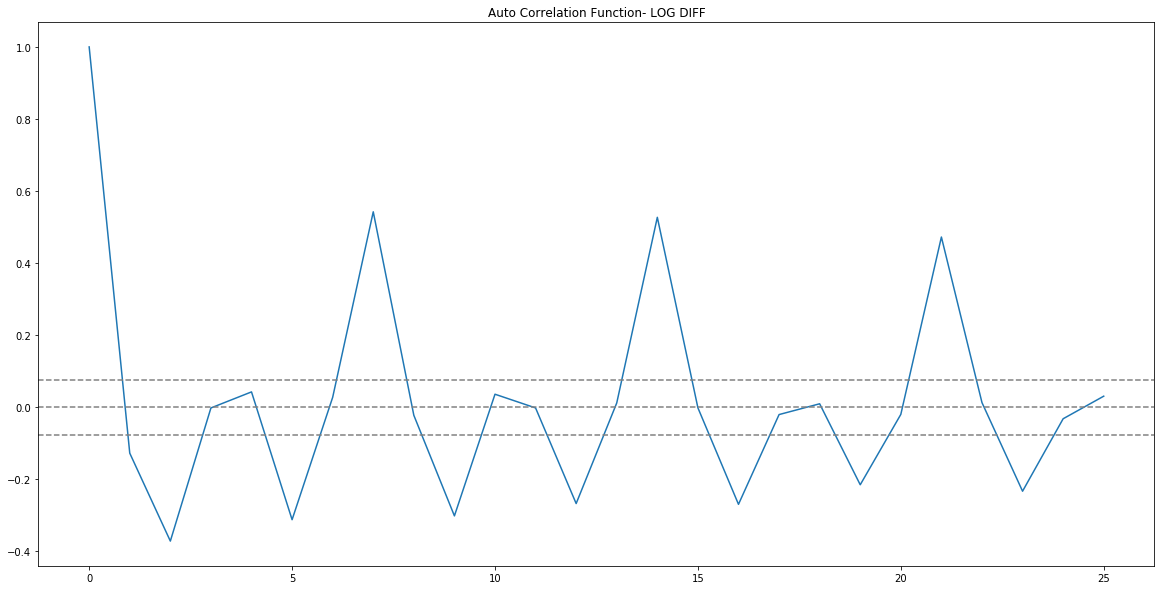

In [19]:
# Plotting ACF
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())), linestyle='--', color='gray')
plt.title('Auto Correlation Function- LOG DIFF')
plt.show()

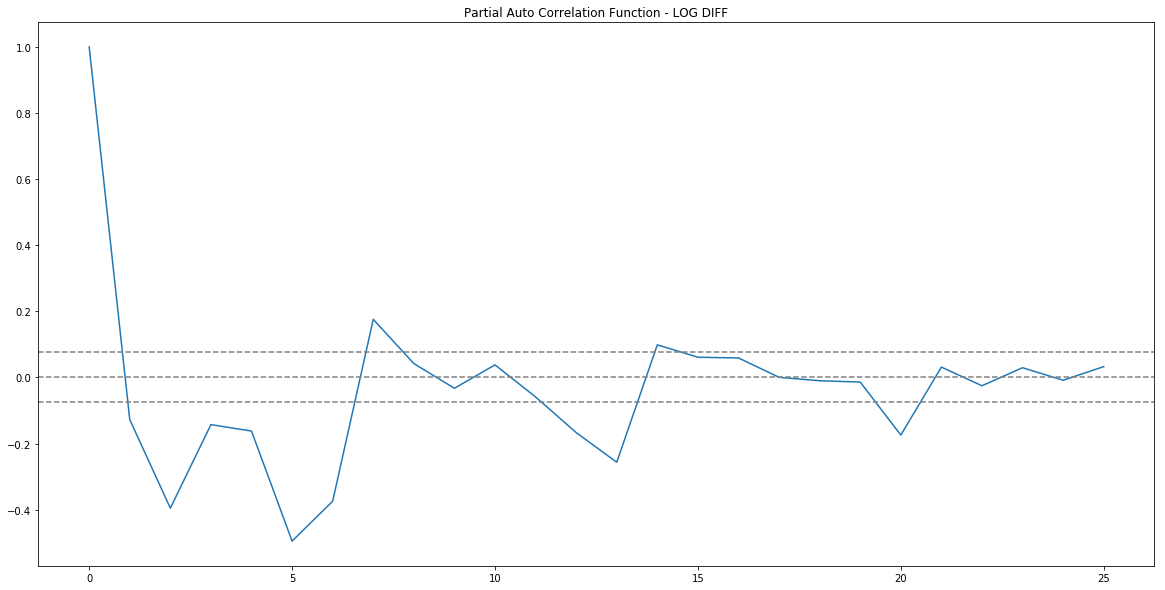

In [20]:
# Plotting PACF
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())), linestyle='--', color='gray')
plt.title('Partial Auto Correlation Function - LOG DIFF')
plt.show()

MODEL

ARIMA

In [21]:
model_ARIMA = ARIMA(Train_log, order=(2, 1, 2))  
results_ARIMA = model_ARIMA.fit(disp=-1)  
plt.plot(train_log_diff.dropna(),  label='original')
plt.plot(results_ARIMA.fittedvalues, color='red', label='predicted')
plt.legend(loc='best')
plt.show()


In [22]:
# Function to Add Trend(Cumulative sum - because of difference done) and Exp(Because of Log for stabilising variance)
def check_prediction_diff(predict_diff, given_set):
    predict_diff = predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(given_set.shape[0]) * np.log(given_set['Count'])[0], index = given_set.index)
    predict_log = predict_base.add(predict_diff,fill_value=0)
    predict = np.exp(predict_log)
    
    plt.plot(given_set['Count'], label="Given set")
    plt.plot(predict, color='red', label="Predict")
    plt.legend(loc='best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
    plt.show()

In [23]:
# Predicting the Count of Validation set
ARIMA_predict_diff = results_ARIMA.predict(start="2014-06-25", end="2014-09-25")

In [24]:
# Scaling the prediction to Original scale
check_prediction_diff(ARIMA_predict_diff, valid)

SARIMA

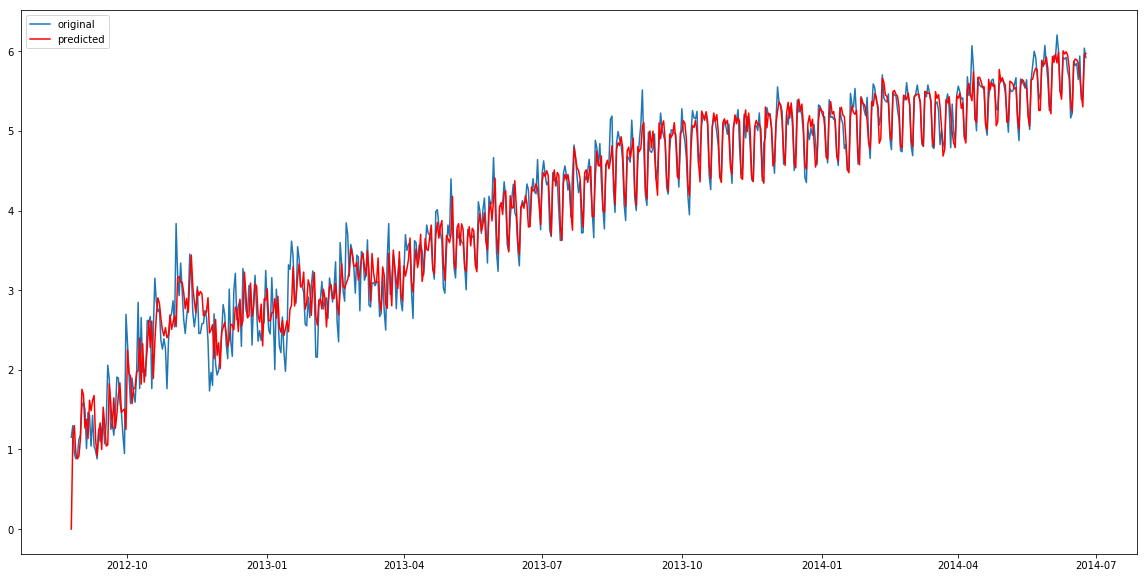

In [25]:
model_SARIMA = sm.tsa.statespace.SARIMAX(Train_log, order=(2, 1, 2), seasonal_order=(0, 1, 1, 7))  
results_SARIMA = model_SARIMA.fit(disp=-1)  
plt.plot(Train_log.dropna(),  label='original')
plt.plot(results_SARIMA.fittedvalues, color='red', label='predicted')
plt.legend(loc='best')
plt.show()

In [26]:
# Function to Exp(Because of Log for stabilising variance)
def check_prediction(predict_diff, given_set):
    predict = np.exp(predict_diff)
    
    plt.plot(given_set['Count'], label="Given set")
    plt.plot(predict, color='red', label="Predict")
    plt.legend(loc='best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
    plt.show()

In [27]:
# Predicting the Count of Validation set
SARIMA_predict = results_SARIMA.predict(start="2014-06-25", end="2014-09-25")

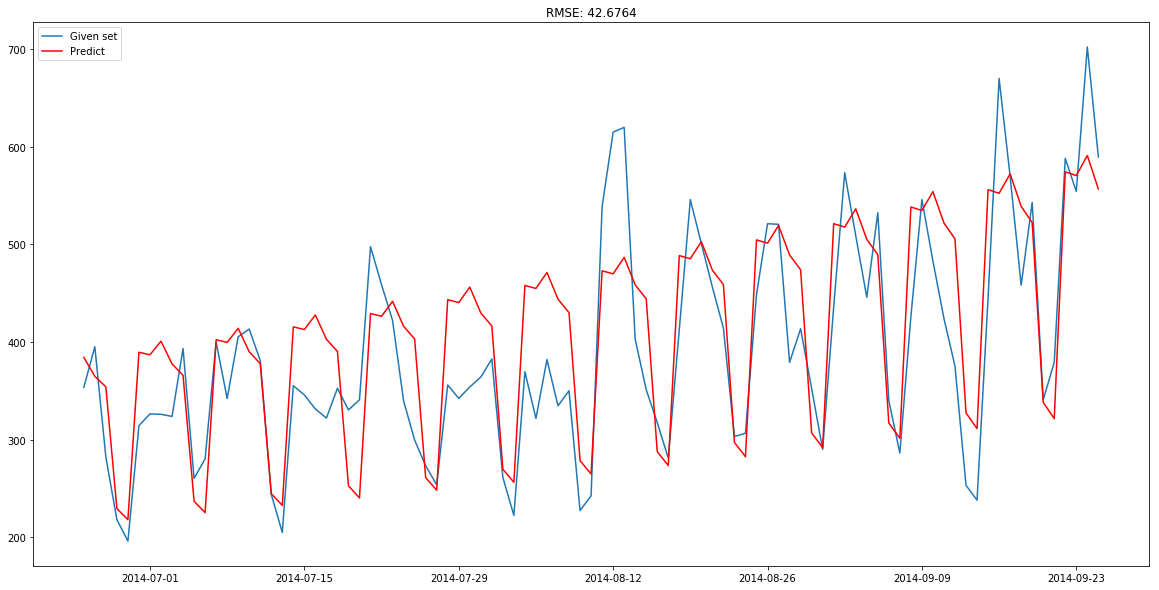

In [28]:
# Scaling the prediction to Original scale
check_prediction(SARIMA_predict, valid)

In [29]:
# RMSE - Validation set
SARIMA_predict_valid = np.exp(SARIMA_predict)
rmse_SARIMA = sqrt(mean_squared_error(valid.Count, SARIMA_predict_valid))

SUBMISSION FOR TEST

In [31]:
# Loading the Submission or Test set
submission = pd.read_csv("data\\Sample_Submission_QChS6c3.csv")

In [32]:
# Prediction of test set
SARIMA_predict_test = np.exp(results_SARIMA.predict(start="2014-9-26", end="2015-4-26"))
test['prediction'] = SARIMA_predict_test

In [33]:
# Ratio of Riders per hour to the total riders on a day
train_original['ratio'] = train_original['Count']/train_original['Count'].sum()
temp = train_original.groupby(['hour'])['ratio'].sum()
pd.DataFrame(temp, columns=['ratio']).to_csv('output\\GROUPby.csv')

In [35]:
temp2 = pd.read_csv("output\\GROUPby.csv")

In [34]:
# Changing the daily predictions to hourly prediction based on the ratio and merging with the submission set
merge = pd.merge(test, test_original, on=['day', 'month', 'year'], how='left')
merge['hour'] = merge['hour_y']
merge = merge.drop(['year', 'month', 'Datetime', 'hour_x', 'hour_y'], axis=1)
prediction = pd.merge(merge, temp2, on='hour', how='left')
prediction['Count'] = prediction['prediction']*prediction['ratio']*24
prediction['ID'] = prediction['ID_y']

In [35]:
# Dropping the unwanted columns
submission = prediction.drop(['ID_x', 'day', 'ID_y', 'prediction', 'hour', 'ratio'], axis=1)

In [36]:
# Final excel sheet
pd.DataFrame(submission, columns=['ID', 'Count']).to_csv('output\\SARIMAX_LOG.csv')